# DAP3 - Classification 
### John Munar and Jack Witt
We first explore the models themsevles (kNN, Bayes, D-Tree) and find what we observed to be the optimal parameters. Next, we created a data structue of our models with our chosen parameters, and conducted 10-fold cross validation to ensure our models were as accurate as possible. Finally, we conducted basic performance metrics for each of the models, using a confusion matrix, performance report, and ROC curves where applicable.

## Imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import MinMaxScaler

In [2]:
# grab data and split
df = pd.read_csv("../DAP2/processeddata/2018_Financial_Data.csv", index_col=0)
target_cols = ['priceCashFlowRatio', 
               'priceEarningsRatio', 
               'priceEarningsToGrowthRatio', 
               'priceBookValueRatio', 
               'currentRatio', 
               'quickRatio',
               'payoutRatio']
X = df[target_cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Model 

Highest Accuracy (no-reg): 0.78239608801956 at k = 15
Highest Accuracy (reg): 0.7775061124694377 at k = 15


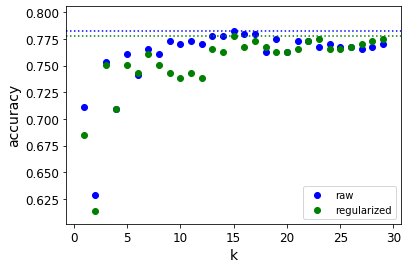

In [3]:
# create and fine tune kNN model
from sklearn.neighbors import KNeighborsClassifier

# find optimal k 
k_range = range(1,30)
scores = []
reg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    # primary fit
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
    # regularized fit
    knn.fit(X_train_scaled, y_train)
    reg_scores.append(knn.score(X_test_scaled, y_test))
    
# plot scores and find maximum
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores, c='b')
plt.scatter(k_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+1
m_indexR = reg_scores.index(mR)+1
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (no-reg): 0.6310975609756097 training on 80.0 % data
Best Partition (reg): 0.6344743276283618 training on 50.0 % data


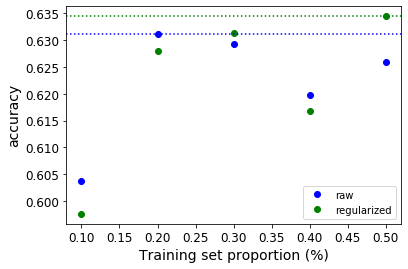

In [24]:
# find optimal testing versus training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
knn = KNeighborsClassifier(n_neighbors = m_indexR) # use index of highest accuracy on regularized dataset
plt.figure()

nr = []
r = []
for s in t:
    scores = []
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # normal fit
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
        # regularized fit 
        knn.fit(X_train_scaled, y_train)
        reg_scores.append(knn.score(X_test_scaled, y_test))
        
    nr.append(np.mean(scores))
    plt.plot(s, nr[-1], 'bo')
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['raw', 'regularized'])
md = max(nr)
mdR = max(r)
md_index = t[nr.index(md)]
md_indexR = t[r.index(mdR)]
plt.axhline(y=md, color='b', linestyle=':')
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (no-reg):',md,'training on',100-md_index*100,'% data')
print('Best Partition (reg):',mdR,'training on', 100-md_indexR*100,'% data')

## Naïve Bayes Model

In [25]:
# re-split and train data for fresh start
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# create and find optimal NB
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)
print('Non-Regularized')
print('Accuracy on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

nbclf = GaussianNB().fit(X_train_scaled, y_train)
print('\nRegularized')
print('Accuracy on training set: {:.2f}'
     .format(nbclf.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(nbclf.score(X_test_scaled, y_test)))

Non-Regularized
Accuracy on training set: 0.73
Accuracy on test set: 0.74

Regularized
Accuracy on training set: 0.73
Accuracy on test set: 0.74


Best Partition (reg): 0.7404580152671757 training on 60.0 % data


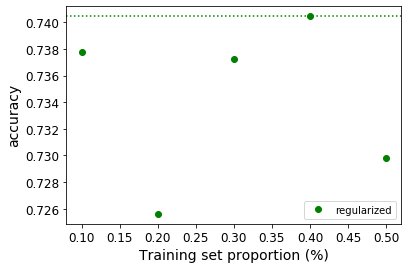

In [28]:
# find optimal testing vs training split size
num_tests = 1000 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit 
        nbclf = GaussianNB().fit(X_train_scaled, y_train)
        reg_scores.append(nbclf.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

## Decision Tree (Entropy)

In [30]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Highest Accuracy (no-reg): 0.7652811735941321 at k = 3
Highest Accuracy (reg): 0.7652811735941321 at k = 3


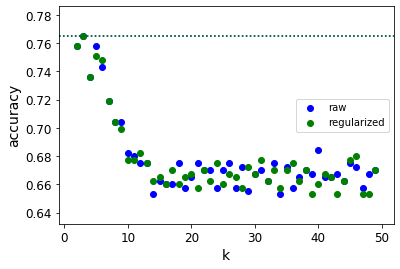

In [31]:
# import and create our decision tree
from sklearn.tree import DecisionTreeClassifier

depth_range = range(2, 50)
scores = []
reg_scores = []

for depth in depth_range:
    tree_entropy = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    tree_entropy.fit(X_train, y_train)
    
    scores.append(tree_entropy.score(X_test, y_test))
    
    tree_entropy.fit(X_train_scaled, y_train)
    reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
    
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(depth_range, scores, c='b')
plt.scatter(depth_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+2
m_indexR = reg_scores.index(mR)+2
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (reg): 0.7926829268292686 training on 90.0 % data


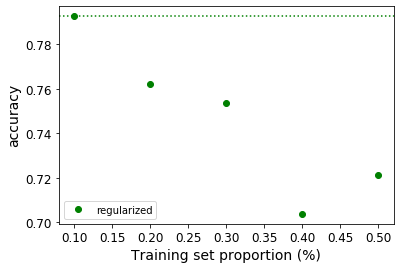

In [32]:
# find optimal testing vs training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit and score
        tree_entropy = DecisionTreeClassifier(max_depth=m_indexR, criterion='entropy') # use optimal depth from above cell
        tree_entropy.fit(X_train_scaled, y_train)
        reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

## Decision Tree (Gini)

In [33]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Highest Accuracy (no-reg): 0.78239608801956 at k = 2
Highest Accuracy (reg): 0.78239608801956 at k = 2


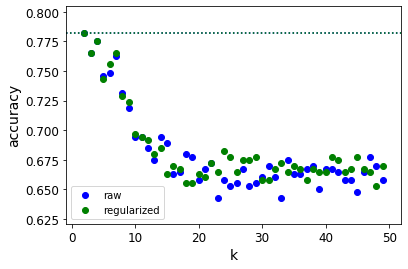

In [34]:
# find optimal parameters
scores = []
reg_scores = []
for depth in depth_range:
    tree_entropy = DecisionTreeClassifier(max_depth=depth, criterion='gini')
    tree_entropy.fit(X_train, y_train)
    
    scores.append(tree_entropy.score(X_test, y_test))
    
    tree_entropy.fit(X_train_scaled, y_train)
    reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
    
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(depth_range, scores, c='b')
plt.scatter(depth_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+2
m_indexR = reg_scores.index(mR)+2
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (reg): 0.7865853658536586 training on 90.0 % data


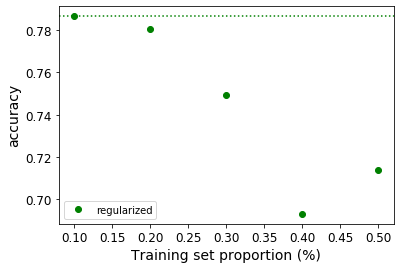

In [36]:
# find optimal testing vs training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit and score
        tree_entropy = DecisionTreeClassifier(max_depth=m_indexR, criterion='gini') # use optimal depth from above cell
        tree_entropy.fit(X_train_scaled, y_train)
        reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

# Data Structure of our Models 
Now that we have our optimal parameters, we can begin applying our 10-fold cv

In [37]:
# create dict of classifiers 
cls = {
    'KNN_15'     : { 'optimalPartition' : 0.5, 'model' : KNeighborsClassifier(n_neighbors = 15) },
    'NB'         : { 'optimalPartition' : 0.6, 'model' : GaussianNB() },
    'DT_entropy' : { 'optimalPartition' : 0.9, 'model' : DecisionTreeClassifier(max_depth=3, criterion='entropy') },
    'DT_gini'    : { 'optimalPartition' : 0.9, 'model' : DecisionTreeClassifier(max_depth=2, criterion='gini') }
}

In [43]:
# create cv 
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=None, shuffle=True) 

# apply 10-fold cv to all of the models and find optimal data partition
for cl in cls: 
    reports = []
    # re-split the data for each new partition 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = cls[cl]['optimalPartition'], random_state=0)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # apply our cv 
    for train_index, test_index in kf.split(X_train):
        cv_X_train   = X_train.iloc[train_index]
        cv_X_test    = X_train.iloc[test_index]
        cv_y_train   = y_train.iloc[train_index]
        cv_y_test    = y_train.iloc[test_index]
       
        cls[cl]['model'].fit(cv_X_train, cv_y_train)
        pred = cls[cl]['model'].score(cv_X_test, cv_y_test)
            
        reports.append(pred) # classification_report(y_test, pred)) FIX LATER
        
    # print average report after cv applied to model
    print(cl,' - ',np.mean(reports))
    

KNN_15  -  0.7553899427883168
NB  -  0.7277468563182848
DT_entropy  -  0.7547205368633941
DT_gini  -  0.7594870380584666


In [ ]:
# train the models under optimal conditions 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = cls[cl]['optimalPartition'], random_state=0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# TO DO 
# 1.) print average classification reports 
# 2.) train the models on the same data
# 3.) eval the models
#       - confusion matrix
#       - performace results 
#       - ROC curves
#       - d trees important features 
# 4.) summary and discussion of optimal parameters 